# FN6815 Numerical Methods for Financial Instrument Pricing

# Lecture 10: Solve PDE (the Black-Scholes PDE)

-   Dr. Yang Ye
-   Email: yy@runchee.com
-   2019/2020 Mini 5


Although we have introduced monte carlo method as an "universal method" for pricing options. It has limitations for how much computational time it takes.

The Monte Carlo method, while often touted as a "universal method" for pricing options, has its limitations, particularly in terms of computational time.

Path-dependent options, such as barrier options (e.g., 'up-and-out'), are event-triggered. Their payoff depends on the path taken by the underlying asset's price. When setting up the Monte Carlo method for these options, we need many fixings which translates into small time steps. This could significantly increase the computational time.

One way to address this issue is by solving the Partial Differential Equation (PDE) associated with the option pricing problem using the Finite Difference Method (FDM). The FDM potentially offers a more efficient and accurate approach for pricing path-dependent options.

It's important to note, however, that while FDM can improve efficiency and accuracy, it also comes with its own set of assumptions and limitations.


The Monte Carlo (MC) method can be used to price barrier options, but it's a good example to illustrate the advantage and limitations of the MC method.

Consider the following code, the MC method implementation is rather simple and straightforward. We simulate the stock price path and calculate the payoff from those paths are always under the barrier (for 'up-and-out' options).

Despite the simplicity, it runs for approximately 0.5 seconds on a standard laptop. The result still has a standard deviation of about 0.11, demonstrating the potential inefficiency and inaccuracy of the MC method for this use case.


In [1]:
%%timeit -r 1 -n 1

import numpy as np
import numpy.random as npr

S_0 = 100
strike = 100
rf = 0.1
sigma = 0.2
ttm = 1
year_frac = 252
sim_points = int(year_frac * ttm)
dt = 1 / year_frac
barrier = 120

npr.seed(123)

M = 100_000
N = sim_points

zs = npr.normal(size=(M, N))
delta_t = ttm / N
loc = (rf - 0.5 * sigma**2) * delta_t
scale = sigma * np.sqrt(delta_t)


def gbm_path_z_m(S_0, a, b, z):
    zs = np.cumsum(a + b * z, axis=1)
    S = S_0 * np.exp(zs)
    return S


def pay_off_barrier_upper_and_out(S_arr, strike, barrier):
    res = np.zeros(S_arr.shape[0])
    no_out_index = np.where(S_arr.max(axis=1) < barrier)
    res[no_out_index] = np.maximum(S_arr[no_out_index, -1] - strike, 0)
    return res


gbm_paths = gbm_path_z_m(S_0, loc, scale, zs)
barrier_po = pay_off_barrier_upper_and_out(gbm_paths, strike, barrier)

display(
    ("barrier", np.exp(-rf * ttm) * barrier_po.mean(), barrier_po.std() / np.sqrt(M))
)

('barrier', 1.3379699603186765, 0.01170955430066662)

753 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## 1. Solving PDE

PDEs involve multivariate functions and their derivatives. A general form of a PDE is:

$$
f = a(x,t) \frac {\partial f} {\partial t} + b(x,t) \frac {\partial f} {\partial x}
$$

For ODE, we iterate each variable's change from other dependent variables. We need **initial conditions (IC)** is required solve ODE such that we can start from somewhere.

For PDE, similarly, we iterate each dependent variable to $f$. PDE is at least dependent on two variables. We need both **initial conditions (IC)** and **boundary conditions (BC)** to solve PDE.

In the Black-Scholes model, the option value is a function of time $t$ and asset price $S$, with other variables (risk-free rate, volatility, etc.) held constant. The boundary conditions are defined by $t = T$, $S = 0$ and $S = S_{max}$.

### 1.1 General Approach to Solve PDEs

1. **Numerical Differentiation**: We approximate partial derivatives with linear functions. With boundary conditions, we can evolve to our answer.

$$
f_{i,j} = a(x,t) \frac {f_{i,j+1} - f_{i,j}} {\Delta t} + b(x,t) \frac {f_{i+1,j} - f_{i,j}} {\Delta x}
$$

2. **Simplified Case**: Consider a case where $a(x,t)$ and $b(x,t)$ are constants $c_1$ and $c_2$,

    $$
    ({\Delta t} {\Delta x} + c_1 {\Delta x} + c_2 {\Delta t}) f_{i,j} = c_1 f_{i,j+1} {\Delta x} + c_2 f_{i+1,j} {\Delta t}
    $$

3. **Rearranging Terms**: We put items of the same $j$ on the left

    $$
    ({\Delta t} {\Delta x} + c_1 {\Delta x} + c_2 {\Delta t}) f_{i,j} - c_2 f_{i+1,j} {\Delta t} = c_1 f_{i,j+1} {\Delta x}
    $$

4. **Initial Condition (IC)**: We start from the known values of $f(i,0)$. We use two values $f_{i,j}$ and $f_{i+1,j}$ on $j$ to solve for $f_{i,j+1}$ on $j+1$ so that we are solving along from $j$ to $j+1$.

5. **Boundary Condition (BC)**: We limit $i$ within a certain range. The value of $f$ on this boundary is referred to as the "boundary condition". For all values on $f_{:,j+1}$, there are equations on the adjacent $i$ values that enable us to solve for $f_{i+1,j+1}$.

$$
({\Delta t} {\Delta x} + c_1 {\Delta x} + c_2 {\Delta t}) f_{i+1,j} - c_2 f_{i+2,j} {\Delta t} = f_{i+1,j+1}
$$

The IC and BC are important. Without them, the solution is not unique and numerical method would not work.

The Euler method is a simple example of a finite difference method. It is a first-order method, which means that the error is proportional to the square of the step size. Higher-order methods, such as the Runge-Kutta method, can be used to reduce the error.

#### Challenges in Solving PDEs

While the general approach to solving PDEs may seem straightforward, there are several challenges:

1. **Stability**: The numerical method must be stable, meaning that small changes in input do not lead to large changes in output.

2. **Accuracy**: The numerical approximation must be accurate, meaning that it closely approximates the true solution.

3. **Efficiency**: The numerical method must be efficient, meaning that it does not require excessive computational resources.

4. **Complexity**: PDEs can be complex and difficult to solve, especially when they involve multiple variables and complex boundary conditions.

In section below, we will unfold the details of solving the Black-Scholes PDE using the finite difference method.


## 2. Black-Scholes PDE

### 2.1 Recap on GBM, Ito's Lemma, and Derivation of BS PDE

Let's denote $S$ as the stock price, $t$ as time, and $V=V(S,t)$ as the option price.

Consider a portfolio with $1$ option and $\delta$ stocks. The value of the portfolio is $P=V+\delta S$, and the change in the portfolio value is $dP=dV+\delta dS$.

1. **Asset Dynamics**: The dynamic of the asset is given by the Geometric Brownian Motion (GBM):

$$
dS=\mu S dt+\sigma S dW
$$

2. **Ito's Lemma**: Applying Ito's lemma, we get:

$$dV = \frac {\partial V} {\partial S} \sigma S dW + (\frac {\partial V} {\partial t} + \mu S \frac {\partial V} {\partial S} + \frac 1 2 \frac {\partial^2 V} {\partial S^2} (S^2 \sigma^2))dt$$

3. **Portfolio Dynamics**: Therefore, the change in the portfolio value is:

$$
dP = (\frac {\partial V} {\partial S} \sigma S + \delta \sigma S) dW + (\frac {\partial V} {\partial t} + \mu S \frac {\partial V} {\partial S} + \frac 1 2 \frac {\partial^2 V} {\partial S^2} (S^2 \sigma^2) + \delta \mu S)dt
$$

4. **Risk-Neutral Portfolio**: Let $\delta = -\frac {\partial V} {\partial S}$ to make our portfolio risk neutral. This also eliminates the randomness, we have

$$
dP = (\frac {\partial V} {\partial t} + \frac 1 2 \frac {\partial^2 V} {\partial S^2} (S^2 \sigma^2))dt
$$

5. **Portfolio Dynamics**: With $dP = \mu P dt$

$$
\frac {dP} {dt} = \mu P = \mu V - \mu S \frac {\partial V} {\partial S}
$$

6. **Black-Scholes PDE**: Finally, we have the PDE

$$
\frac {\partial V} {\partial t} + \mu S \frac {\partial V} {\partial S} + \frac {1} {2} S^2 \sigma^2 \frac {\partial^2 V} {\partial S^2} - \mu V= 0
$$

7. **Boundary Conditions**: To solve this PDE numerically, we need to bound the solution within:

$$
\text{for}\, 0\leq S\leq S_{max}, t \in [0, T)
$$

This is the process of deriving the Black-Scholes PDE from the dynamics of the asset and the portfolio. The resulting PDE can be solved numerically given the appropriate boundary conditions.


#### Initial and Boundary Conditions for Black-Scholes PDE

##### Option Payoff as the Initial Condition

If we view the end time $T$ as the start (working backwards), $t$ as the option payoff serves as the initial condition:

$$V(S, T) = \text{payoff of the derivative}$$

Consider the following derivative payoffs:

-   **Stock Holding**: $V(S, T) = S$. This is equivalent to holding a stock.
-   **Cash at Maturity**: $V(S, T) = C$. This is equivalent to receiving a cash amount $C$ at $T$, so $V(S, t) = Ce^{−r(T−t)}$.
-   **Binary Option**: $V(S, T) = 1 \text{ if } S > K \text{ else } 0$. The value of a binary option is $V(S,t) = e^{−r(T−t)} N(d_2)$.

Substituting these payoffs into the PDE confirms that they are indeed solutions.

![ic_value](img/10/ic_value.png)

##### Boundary Conditions

-   **At Expiry**: $f (T, S)$ is known when the option expires.
-   **Stock Price Drops to 0**: $f (t, 0)$ can be calculated when the stock’s price drops to 0.
-   **Stock Price is at a high value**: $f (t, S_{max})$ can be calculated when the stock’s price is at a high value.

The goal is to calculate $f(0, S)$, the option price at the current time for different stock prices.


### 2.2 Solve BS PDE Numerically

#### 2.2.1 Numerical Differentiation

We can apply numerical differentiation to the Black-Scholes PDE:

$$
\frac {\partial f} {\partial t} + \frac 1 2 \sigma^2 S^2 \frac {\partial^2 f} {\partial S^2} + r S \frac {\partial f} {\partial S} - rf = 0
$$

Consider an interior point $(i, j)$ where $i \in [0,N+1]$ and $j \in [0,M+1]$. We divide the space into $N*M$ grids.

Let $f_{i,j}$ denote the value of the option at the $(i, j)$ point. We can approximate the derivatives in the PDE using finite differences at this point.


Question: How to draw the relationship between these four points?

-   $f(i,j)$
-   $f(i+1,j)$
-   $f(i,j+1)$
-   $f(i,j-1)$

Hint: $j$ is the direction of time, and $i$ is the direction of stock price.


1. **Central Differences for $\frac {\partial f} {\partial S}$ and $\frac {\partial^2 f} {\partial S^2}$**:

The first-order derivative with respect to $S$ can be approximated using a central difference:

$$
\frac {\partial f} {\partial S} = \frac {f(i,j+1) - f(i,j-1)} {2\Delta S}
$$

The second-order derivative with respect to $S$ can also be approximated using a central difference:

$$
\frac {\partial^2 f} {\partial S^2} = \frac {f(i,j+1) - 2f(i,j) + f(i,j-1)} {\Delta S^2}
$$

2. **Forward Difference for $\frac {\partial f} {\partial t}$**:

The derivative with respect to $t$ can be approximated using a forward difference:

$$
\left. { \frac {\partial f} {\partial t} } \right| {_{i}} = \frac {f(i+1,j) - f(i,j)} {\Delta t}
$$

These numerical differentiation approximations can be substituted into the Black-Scholes PDE to obtain a discretized version of the equation that can be solved numerically.


#### 2.2.2 Transforming the Black-Scholes PDE to Algebraic Equations

By substituting the numerical differentiation approximations into the Black-Scholes PDE, we can transform the PDE into a system of algebraic equations:

$$
\frac {f(i+1,j) - f(i,j)} {\Delta t} + \frac 1 2 \sigma^2 S^2 (\frac {f(i,j+1) - 2f(i,j) + f(i,j-1)} {\Delta S^2}) + rS (\frac {f(i,j+1) - f(i,j-1)} {2\Delta S}) = rf(i,j)
$$

On our grid of [0, T] and [0, S], we make the index $i$, $j$ for $t=i\Delta t$ and $S=j\Delta S$. This gives us:

$$
\frac {f(i+1,j) - f(i,j)} {\Delta t} + \frac 1 2 \sigma^2 j^2 ({f(i,j+1) - 2f(i,j) + f(i,j-1)}) + \frac {1} {2} r j ({f(i,j+1) - f(i,j-1)}) = rf(i,j)
$$


$$
\begin{aligned}
& f(i+1,j) - f(i,j) \\
& + \frac 1 2 \sigma^2 j^2 ({f(i,j+1) - 2f(i,j) + f(i,j-1)})  {\Delta t} \\
& + \frac {1} {2} r j ({f(i,j+1) - f(i,j-1)}) {\Delta t} \\
& = rf(i,j) {\Delta t} \\
\\
f(i+1,j) & =
r{\Delta t} f(i,j) + f(i,j) \\
& + \sigma^2 j^2  f(i,j) {\Delta t}  \\
& - \frac 1 2 \sigma^2 j^2 f(i,j+1) {\Delta t} \\
& - \frac 1 2 \sigma^2 j^2 f(i,j-1) {\Delta t} \\
& - \frac 1 2 r j f(i,j+1) {\Delta t} \\
& + \frac 1 2 r j f(i,j-1) {\Delta t}
\\
f(i+1,j) & =
( \frac 1 2 r j - \frac 1 2 \sigma^2 j^2 {\Delta t} ) f(i,j-1) \\
& + (1 + r{\Delta t} + \sigma^2 j^2 {\Delta t}) f(i,j) \\
& + (- \frac 1 2 \sigma^2 j^2 {\Delta t} - \frac 1 2 r j {\Delta t} ) f(i,j+1)
\end{aligned}
$$


#### 2.2.3 Solution

To simplify notation, let's use $f_{i,j}$ to denote $f(i,j)$.

$$
a_j f_{i,j-1} + b_j f_{i,j} + c_j f_{i,j+1} = f_{i+1,j}, \text{for}\, i = 0,\dots,N-1, \text{and}\, j = 1,2,\dots,M-1
$$

where

$$
\begin{aligned}
a_j & = \frac 1 2 r j \Delta t - \frac 1 2 \sigma^2 j^2 \Delta t \\
b_j & = 1 + \sigma^2 j^2 \Delta t + r \Delta t \\
c_j & = -\frac 1 2 r j \Delta t - \frac 1 2 \sigma^2 j^2 \Delta t
\end{aligned}
$$

The coefficients $a_j$, $b_j$, $c_j$ are independent of $i$ (non-time dependent), and only dependent on $j$ (underlying-dependent).

Consider the initial and boundary conditions for European Put options:

(1) Initial Condition (IC): $f_{N,j} = \max(K - j \Delta S)$ for $j = 0, 1, \dots M$

(2) Boundary Condition (BC): $f_{i,0} = K e^{-r(T-i\Delta t)} - S_{min}$, for $i = 0, 1, \dots N$

(3) Boundary Condition (BC): Since $f \rightarrow 0$ as $S \rightarrow +\infty$, choose $f_{i,M} = 0$ for $i = 0, 1 \dots N$

For European Call options, the IC and BC are different:

(1) Initial Condition (IC): $f_{N,j} = \max(j \Delta S - K)$ for $j = 0, 1, \dots M$

(2) Boundary Condition (BC): $f_{i,0} = 0$, for $i = 0, 1, \dots N$

(3) Boundary Condition (BC): $f_{i,M} = S_{max} - K e^{-r(T-i\Delta t)}$, for $i = 0, 1, \dots N$

On the IC, there are $M+1$ points, from 0 to M. On the BC, there are $N+1$ points, from 0 to N.

We have all the interior points and one boundary to be determined. Therefore, there are $(M-1)(N-1)+N-1=M(N-1)$ unknown points.

We can solve for these unknowns backward in time, which means $i = N-1$ to $0$.


#### Call-Put Parity and Boundary Conditions

The boundary conditions for Call and Put options follow the Call-Put parity principle:

$$C - P = S - K e^{-rT} $$

-   **Upper-Price Boundary**: For a Put option, $P = 0$, so the Call option price $C = S - K e^{-rT}$.
-   **Lower-Price Boundary**: For a Call option, $C = 0$, so the Put option price $P = K e^{-rT} - S$.

This relationship ensures that no arbitrage opportunities exist between the prices of Call and Put options. It's a fundamental principle in options pricing and is used to derive the boundary conditions for solving the Black-Scholes PDE numerically.


#### 2.2.4 Efficient Solution for Black-Scholes PDE

##### Formulating the Problem

We have the following equation describing the relationship between four points: $f_{i+1,j}$, $f_{i,j-1}$, $f_{i,j}$, and $f_{i,j+1}$:

$$
a_j f_{i,j-1} + b_j f_{i,j} + c_j f_{i,j+1} = f_{i+1,j}, \text{for}\, i = N-1,\dots,0, \text{and}\, j = 1,2,\dots,M-1
$$

We solve the equations from $i=N-1$ to $0$ (backward in time) and $j=1$ to $M-1$ (excluding boundaries). We have $M$ intervals for underlying asset prices and $N$ intervals for time.

##### Matrix Formulation

The system of equations can be arranged in matrix form:

$$
\begin{bmatrix}
b_1 & c_1 & & & & & \\
a_2 & b_2 & c_2 & & & & \\
 & a_3 & b_3 & c_3 & & & \\
 & & \dots & \dots & \dots & & \\
 & & & \dots & \dots & \dots & \\
 & & & & & a_{M-1} & b_{M-1}\\
\end{bmatrix} \begin{bmatrix}
f(i,1) \\
f(i,2) \\
f(i,3) \\
\dots \\
\dots \\
f(i,M-1) \\
\end{bmatrix} = \begin{bmatrix}
& f(i+1,1) - a_1 \mathbf{f(i,0)} = b_1 f(i,1) + c_1 f(i,2)\\
& f(i+1,2) = a_2 f(i,1) + b_2 f(i,2) + c_2 f(i,3) \\
& f(i+1,3) = a_3 f(i,2) + b_3 f(i,3) + c_3 f(i,4) \\
& \dots \\
& \dots \\
& f(i+1,M-1) - c_{M-1} \mathbf{f(i,M)} \\
\end{bmatrix}
$$

#### 2.2.5 Discussion and Recap

-   The dimensions are $N − 1$ and $M-1$ because we exclude the boundaries.
-   $f_{i,0}$ and $f_{i,n}$ are the boundary conditions.
-   The implicit method can be implemented using a tridiagonal matrix algorithm.
-   The boundary condition for a call option is derived from the Call-Put parity.

#### 2.2.6 Key points

-   We solve the equation from $i+1$ to $i$ (backward in time), i.e. from T to 0
-   This scheme is called **implicit** as $f_{i,N-1}, f_{i,N}, f_{i,N+1}$ are related to $f(i+1,N)$. We solve a linear equation to get the answer, like Euler backward scheme for ODE.
-   The implicit method requires work per line since the matrix is tridiagonal.
-   The tridiagonal matrix in the implicit finite difference scheme is not necessarily symmetric.
-   Total work time is $O(MN)$.
-   Space requirement is $O(MN)$ if the whole surface on the grid is needed, or $O(M)$ if only the current option value is wanted.


### 2.3 Example

For an European Put

| Parameter      | Value           | Variable |
| -------------- | --------------- | -------- |
| jmax           | 50              | M and j  |
| imax           | 100             | N and i  |
| Maturity       | 1 (year)        | T and t  |
| Strike         | 100             | K        |
| Risk-free Rate | 0.05 (per year) | r        |
| Volatility     | 0.3 (per year)  | sigma    |
| Price Inc.     | 4.00            | delta_p  |
| Time Inc.      | 0.01 (year)     | dt       |


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps


def bs_call(S, strike, ttm, rf, sigma, *w, **kw):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    # We add 0 as stdev
    return S * sps.norm.cdf(d1) - strike * np.exp(-rf * ttm) * sps.norm.cdf(d2)


def bs_put(S, strike, ttm, rf, sigma, *w, **kw):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    # We add 0 as stdev
    return sps.norm.cdf(-d2) * strike * np.exp(-rf * ttm) - sps.norm.cdf(-d1) * S

#### Boundary Condition


n_grid: 5399


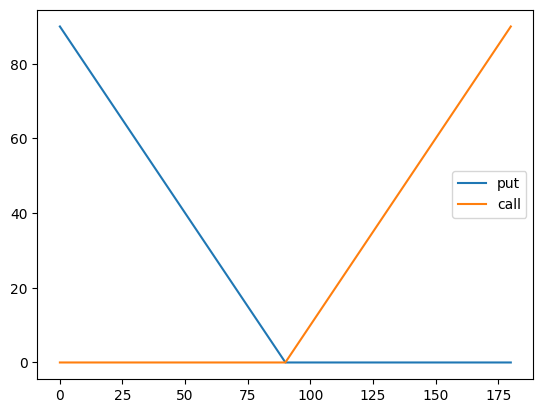

In [3]:
### on time = 1.0
strike = 90
rf = 0.05
sigma = 0.3
ttm = 1
year_frac = 252
sim_points = int(year_frac * ttm)
dt = 1 / year_frac

# n_grid = int(1200/delta_p)+1
# asset_price = np.linspace(strike/3, strike*3, n_grid)

delta_p = 1 / 30
upper_p = strike * 2  # S: [0, 2*strike]
lower_p = 0
n_grid = int((upper_p - lower_p) / delta_p) - 1
asset_price = np.linspace(lower_p + delta_p, upper_p - delta_p, n_grid)

po_put = np.maximum(strike - asset_price, 0)
po_call = np.maximum(asset_price - strike, 0)
print("n_grid:", n_grid)

(pp,) = plt.plot(asset_price, po_put, label="put")
(pc,) = plt.plot(asset_price, po_call, label="call")
plt.legend(handles=[pp, pc])
plt.show()

#### Solving the Algebraic Equations

The algebraic equations derived from the discretized Black-Scholes PDE are:

$$
\begin{aligned}
a_j & = \frac 1 2 r j \Delta t - \frac 1 2 \sigma^2 j^2 \Delta t \\
b_j & = 1 + \sigma^2 j^2 \Delta t + r \Delta t \\
c_j & = -\frac 1 2 r j \Delta t - \frac 1 2 \sigma^2 j^2 \Delta t
\end{aligned}
$$

These equations represent the coefficients of the tridiagonal matrix in the system of linear equations that we need to solve.

-   $a_j$ is the coefficient of $f_{i,j-1}$, the option price at the previous stock price.
-   $b_j$ is the coefficient of $f_{i,j}$, the option price at the current stock price.
-   $c_j$ is the coefficient of $f_{i,j+1}$, the option price at the next stock price.

These coefficients are calculated for each stock price level $j$ and time step $i$. They incorporate the effects of the risk-free rate $r$, the volatility $\sigma$, the stock price $S$, and the time step sizes $\Delta t$ and $\Delta S$.


In [4]:
def Aj(j, rf, dt, sigma):
    Aj = 0.5 * rf * j * dt - 0.5 * (sigma**2) * (j**2) * dt
    return Aj


def Bj(j, rf, dt, sigma):
    Bj = 1 + rf * dt + (sigma**2) * (j**2) * dt
    return Bj


def Cj(j, rf, dt, sigma):
    Cj = (-0.5) * rf * j * dt - 0.5 * (sigma**2) * (j**2) * dt
    return Cj

$$
\begin{bmatrix}
b_1 & c_1 & & & & & \\
a_2 & b_2 & c_2 & & & & \\
 & a_3 & b_3 & c_3 & & & \\
 & & \dots & \dots & \dots & & \\
 & & & \dots & \dots & \dots & \\
 & & & & & a_{M-1} & b_{M-1}\\
\end{bmatrix} \begin{bmatrix}
f(i,1) \\
f(i,2) \\
f(i,3) \\
\dots \\
\dots \\
f(i,M-1) \\
\end{bmatrix} = \begin{bmatrix}
& f(i+1,1) - a_1 \mathbf{f(i,0)} = b_1 f(i,1) + c_1 f(i,2)\\
& f(i+1,2) = a_2 f(i,1) + b_2 f(i,2) + c_2 f(i,3) \\
& f(i+1,3) = a_3 f(i,2) + b_3 f(i,3) + c_3 f(i,4) \\
& \dots \\
& \dots \\
& f(i+1,M-1) - c_{M-1} \mathbf{f(i,M)} \\
\end{bmatrix}
$$


(5399,) (5399, 5399)


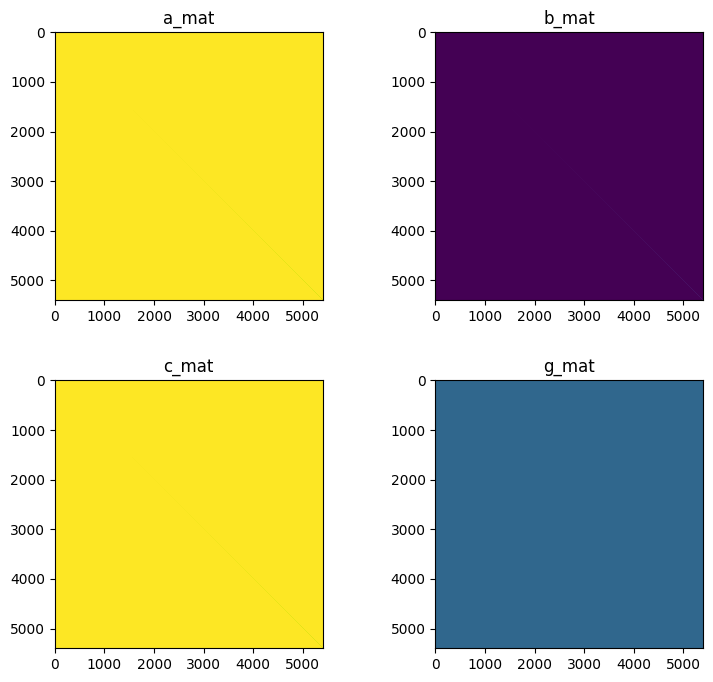

In [5]:
## Python code uses index from 0.
## We shall not confuse the real index (from 1) and python array index (from 0).

b_mat = np.diag([Bj(j, rf, dt, sigma) for j in range(1, n_grid + 1)])
a_mat = np.zeros_like(b_mat)
a_mat[1:, :-1] = np.diag([Aj(j, rf, dt, sigma) for j in range(2, n_grid + 1)])
c_mat = np.zeros_like(b_mat)
c_mat[:-1, 1:] = np.diag([Cj(j, rf, dt, sigma) for j in range(1, n_grid)])

g_mat = a_mat + b_mat + c_mat
g_mat_inv = np.linalg.inv(g_mat)
print(po_call.shape, g_mat_inv.shape)

_, axs = plt.subplots(2, 2, gridspec_kw={"hspace": 0.3}, figsize=(9, 8))
for ax, var in zip(axs.flat, ["a_mat", "b_mat", "c_mat", "g_mat"]):
    x = eval(var)
    ax.imshow(x)
    ax.set_title(var)
plt.show()

In [6]:
# Alternatively, we can use sparse matrix class to speed up calculation.
import scipy.sparse as spsp

sp_g_mat = spsp.diags(
    [
        [Aj(j, rf, dt, sigma) for j in range(2, n_grid + 1)],
        [Bj(j, rf, dt, sigma) for j in range(1, n_grid + 1)],
        [Cj(j, rf, dt, sigma) for j in range(1, n_grid)],
    ],
    [-1, 0, 1],
    (n_grid, n_grid),
).tocsc()

# Ensure the generated sparse matrix is the same as the original dense matrix
assert np.all(sp_g_mat.todense() == g_mat)

a_1:  -7.936507936507934e-05  c_m_1: -5205.750079365079


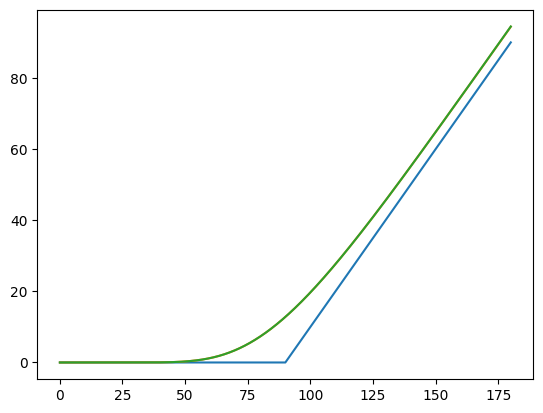

call: (array([2999]),) [100.] [19.69194743]


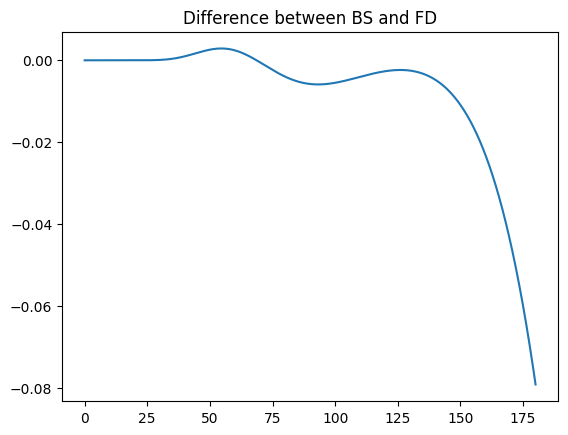

In [7]:
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplg

res = po_call.copy()
a_1 = Aj(1, rf, dt, sigma)
c_m_1 = Cj(n_grid, rf, dt, sigma)

print("a_1: ", a_1, " c_m_1:", c_m_1)

for i in range(sim_points):
    res[0] = res[0] - a_1 * 0
    res[-1] = res[-1] - c_m_1 * (upper_p - strike * np.exp(-rf * (i + 1) * dt))
    # A few ways to solve
    # 1. Direct matrix inverse: very slow
    # res = np.matmul(g_mat_inv, res)
    # 2. Linear Equation solver: slow
    # res = np.linalg.solve(g_mat, res)
    # 3. sparse matrix solver: fast
    res = spsplg.spsolve(sp_g_mat, res)

# This figure is about option price with fixed strike.
plt.plot(asset_price, po_call)
plt.plot(asset_price, res)
plt.plot(asset_price, bs_call(asset_price, strike, ttm, rf, sigma))
plt.show()

plt.plot(asset_price, res - bs_call(asset_price, strike, ttm, rf, sigma))
plt.title("Difference between BS and FD")

price_index = np.where(np.abs(asset_price - 100) == np.min(np.abs(asset_price - 100)))
print("call:", price_index, asset_price[price_index], res[price_index])

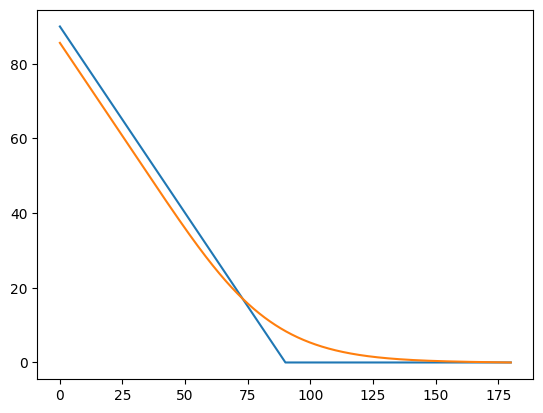

put: [98, 100, 102] [5.82878002 5.30301444 4.81985857]


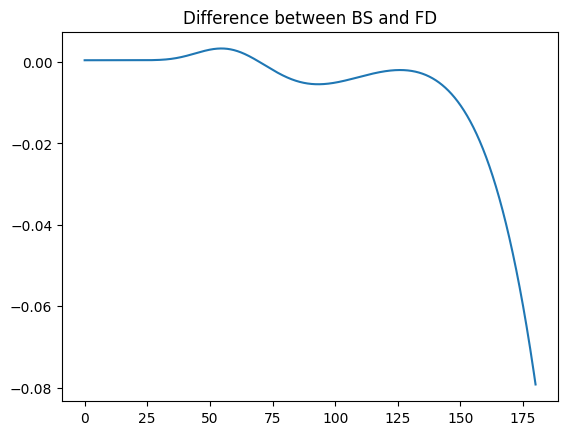

In [8]:
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplg

res = po_put.copy()
a_1 = Aj(1, rf, dt, sigma)
c_m_1 = Cj(n_grid, rf, dt, sigma)
splu_g_mat = spsplg.splu(sp_g_mat)
## print("a_1: ", a_1, " c_m_1:", c_m_1)
for i in range(sim_points):
    res[0] = res[0] - a_1 * (strike * np.exp(-rf * (i + 1) * dt) - lower_p)
    res[-1] = res[-1] - c_m_1 * 0
    ## One more method: splu with LU decomposition: faster
    # res = splu_g_mat.solve(res)
    res = spsplg.spsolve(sp_g_mat, res)

plt.plot(asset_price, po_put)
plt.plot(asset_price, res)
plt.show()

plt.plot(asset_price, res - bs_put(asset_price, strike, ttm, rf, sigma))
plt.title("Difference between BS and FD")

oPrice = np.interp([98, 100, 102], asset_price, res)
print("put:", [98, 100, 102], oPrice)

call/put: (14.231254785985819, 9.354197236057232)
---
N_d_1, N_d_2: 0.9956949235179967 0.9900215517980884
N_d_1_n, N_d_2_n: 0.004305076482003255 0.009978448201911683
call/put@200: (104.96522160757938, 0.08816405765081248)
---
N_d_1, N_d_2: 0.9999996046477596 0.9999982380175715
N_d_1_n, N_d_2_n: 3.9535224043641353e-07 1.761982428463793e-06
call/put@400: (304.8770670139856, 9.464056966233017e-06)
---
N_d_1, N_d_2: 1.0823959355942804e-25 4.426265019533918e-27
N_d_1_n, N_d_2_n: 1.0 1.0
call/put@0: (1.1919021515823096e-26, 91.1229424500714)
---
N_d_1, N_d_2: 1.0 1.0
N_d_1_n, N_d_2_n: 0.0 0.0
call/put@200: (100.0, 0.0)
---
N_d_1, N_d_2: 0.0 0.0
N_d_1_n, N_d_2_n: 1.0 1.0
call/put@0: (0.0, 96.0)
---
[3.33333333e-02 6.66666667e-02 1.00000000e-01 ... 1.79900000e+02
 1.79933333e+02 1.79966667e+02]


/tmp/ipykernel_228264/1901435391.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  d_1 = (np.log(S_0 / strike) + (rf + sigma**2 / 2) * ttm) / (sigma * np.sqrt(ttm))


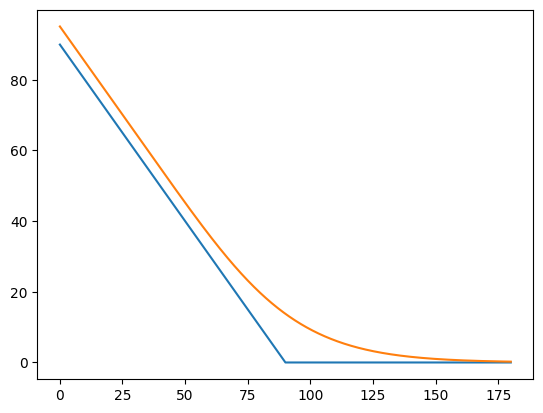

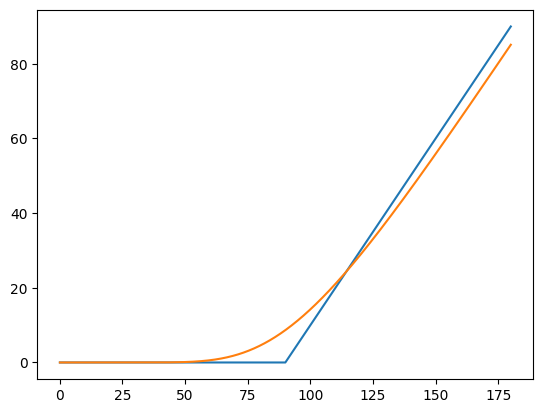

In [9]:
# Compare with Black-Scholes Closed Form

import scipy.stats as sps

S_0 = 100
strike = 100
rf = 0.05
sigma = 0.3
ttm = 1


def bs_pricing(S_0, strike, rf, sigma, ttm, nd_print=False):
    d_1 = (np.log(S_0 / strike) + (rf + sigma**2 / 2) * ttm) / (sigma * np.sqrt(ttm))
    d_2 = d_1 - sigma * np.sqrt(ttm)
    ## print(d_1,d_2)
    ## print(sps.norm.cdf(d_1),sps.norm.cdf(d_2), sps.norm.cdf(-d_1),sps.norm.cdf(-d_2))
    N_d_1 = sps.norm.cdf(d_1)
    N_d_2 = sps.norm.cdf(d_2)
    bs_call = S_0 * N_d_1 - strike * np.exp(-rf * ttm) * N_d_2
    if nd_print:
        print(f"N_d_1, N_d_2: {N_d_1} {N_d_2}")
    N_d_1_n = sps.norm.cdf(-d_1)
    N_d_2_n = sps.norm.cdf(-d_2)
    bs_put = -S_0 * N_d_1_n + strike * np.exp(-rf * ttm) * N_d_2_n
    if nd_print:
        print(f"N_d_1_n, N_d_2_n: {N_d_1_n} {N_d_2_n}")
    return bs_call, bs_put


print("call/put:", bs_pricing(100, strike, rf, sigma, ttm))
print("---")
print("call/put@200:", bs_pricing(200, strike, rf, sigma, ttm, nd_print=True))
print("---")
print("call/put@400:", bs_pricing(400, strike, rf, sigma, ttm, nd_print=True))
print("---")
print("call/put@0:", bs_pricing(4, strike, rf, sigma, ttm, nd_print=True))

print("---")
print("call/put@200:", bs_pricing(200, strike, rf, sigma, 0, nd_print=True))
print("---")
print("call/put@0:", bs_pricing(4, strike, rf, sigma, 0, nd_print=True))

print("---")
print(asset_price)

plt.plot(asset_price, po_put)
plt.plot(asset_price, bs_pricing(asset_price, strike, rf, sigma, ttm)[1])
plt.show()

plt.plot(asset_price, po_call)
plt.plot(asset_price, bs_pricing(asset_price, strike, rf, sigma, ttm)[0])
plt.show()

### 2.4 Barrier Option (Upper and Out)

The FDM for barrier options is similar to the Black-Scholes PDE, but with updated boundary conditions at the barrier level. The boundary conditions for barrier options depend on the type of barrier (e.g., up-and-out, down-and-out, up-and-in, down-and-in).

In fact, the FDM for barrier option has a small range and less number of unknown grid points to be solved, it runs faster than the FDM for European vanilla options.


n_grid: 2399


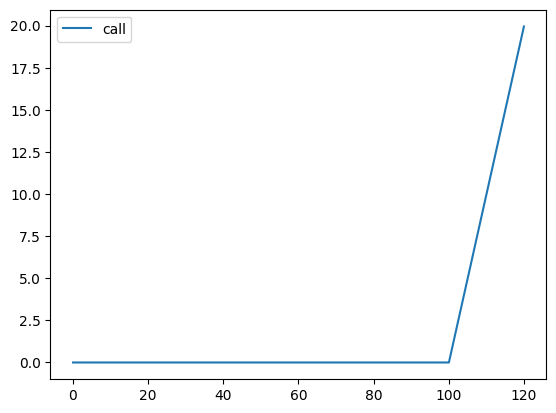

In [10]:
### on time = 1.0
strike = 100
rf = 0.1
sigma = 0.2
ttm = 1
year_frac = 252
sim_points = int(year_frac * ttm)
dt = 1 / year_frac
barrier = 120

# n_grid = int(1200/delta_p)+1
# asset_price = np.linspace(strike/3, strike*3, n_grid)

delta_p = 100 / 2000
upper_p = barrier
lower_p = 0
n_grid = int((upper_p - lower_p) / delta_p) - 1
asset_price = np.linspace(lower_p + delta_p, upper_p - delta_p, n_grid)
po_barrier_call = np.maximum(asset_price - strike, 0)
print("n_grid:", n_grid)

plt.plot(asset_price, po_barrier_call, label="call")
plt.legend()
plt.show()

In [11]:
S0 = 100
T = ttm
K = strike
B = barrier
sig = sigma
r = rf

d1 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r + sig**2 / 2) * t)
d2 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r - sig**2 / 2) * t)


def analytical_barrier(S0, T, K, B, sig, r):
    return (
        S0 * (sps.norm.cdf(d1(T, S0 / K)) - sps.norm.cdf(d1(T, S0 / B)))
        - np.exp(-r * T)
        * K
        * (sps.norm.cdf(d2(T, S0 / K)) - sps.norm.cdf(d2(T, S0 / B)))
        - B
        * (S0 / B) ** (-2 * r / sig**2)
        * (sps.norm.cdf(d1(T, B**2 / (S0 * K))) - sps.norm.cdf(d1(T, B / S0)))
        + np.exp(-r * T)
        * K
        * (S0 / B) ** (-2 * r / sig**2 + 1)
        * (sps.norm.cdf(d2(T, B**2 / (S0 * K))) - sps.norm.cdf(d2(T, B / S0)))
    )


print(
    "The price of the Up and Out call option by analytical formula is: ",
    analytical_barrier(S0, T, K, B, sig, r),
)

The price of the Up and Out call option by analytical formula is:  1.1789018151004562


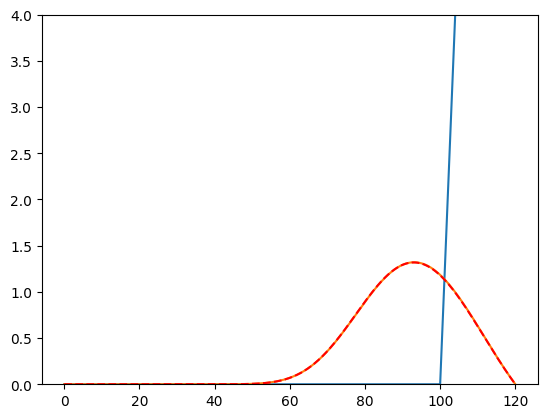

call: (array([1999]),) [100.] [1.18381446]
60.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


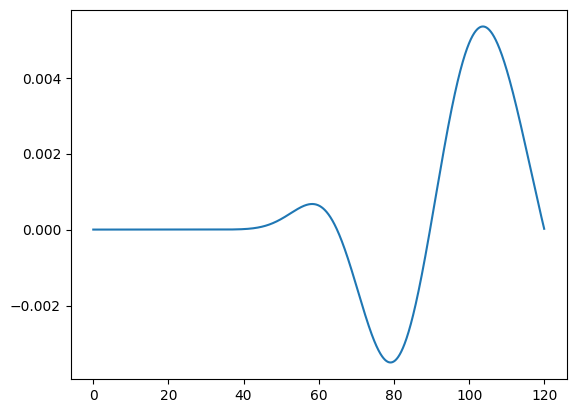

In [12]:
%%timeit -r 1 -n 1


def Aj(j, rf, dt, sigma):
    Aj = 0.5 * rf * j * dt - 0.5 * (sigma**2) * (j**2) * dt
    return Aj


def Bj(j, rf, dt, sigma):
    Bj = 1 + rf * dt + (sigma**2) * (j**2) * dt
    return Bj


def Cj(j, rf, dt, sigma):
    Cj = (-0.5) * rf * j * dt - 0.5 * (sigma**2) * (j**2) * dt
    return Cj


## Python code uses index from 0.
## We shall not confuse the real index (from 1) and python array index (from 0).

# To use sparse matrix class for faster calculation.
sp_g_mat = spsp.diags(
    [
        [Aj(j, rf, dt, sigma) for j in range(2, n_grid + 1)],
        [Bj(j, rf, dt, sigma) for j in range(1, n_grid + 1)],
        [Cj(j, rf, dt, sigma) for j in range(1, n_grid)],
    ],
    [-1, 0, 1],
    (n_grid, n_grid),
).tocsc()

res = po_barrier_call.copy()
a_1 = Aj(1, rf, dt, sigma)
c_m_1 = Cj(n_grid, rf, dt, sigma)
## print("a_1: ", a_1, " c_m_1:", c_m_1)

splu_g_mat = spsplg.splu(sp_g_mat)
for i in range(sim_points):
    res[0] = res[0] - 0
    res[-1] = res[-1] - 0
    res = splu_g_mat.solve(res)
    # res = spsplg.spsolve(sp_g_mat, res)

# This figure is about option price with fixed strike.
plt.plot(asset_price, po_barrier_call)
plt.plot(asset_price, res)
plt.plot(asset_price, analytical_barrier(asset_price, T, K, B, sig, r), "r--")
plt.ylim(0, 4)
plt.show()

plt.plot(asset_price, res - analytical_barrier(asset_price, T, K, B, sig, r))

price_index = np.where(np.abs(asset_price - 100) == np.min(np.abs(asset_price - 100)))
print("call:", price_index, asset_price[price_index], res[price_index])

### 2.5 Explicit Method (Optional)

The Explicit Method allows us to directly calculate $f(i, N)$ based on $f(i+1, N)$.

#### Numerical Differentiation:

We use central difference for first derivative in S:

$$
\frac {\partial f} {\partial S} = \frac {f(i+1,j+1) - f(i+1,j-1)} {2\Delta S}
$$

And central difference for second derivative in S:

$$
\frac {\partial^2 f} {\partial S^2} = \frac {f(i+1,j+1) - 2f(i+1,j) + f(i+1,j-1)} {\Delta S^2}
$$

#### Backward in Time

$$
\left. {\frac {\partial f} {\partial t}} \right | {_{i+1}} = \frac {f(i+1,j) - f(i,j)} {\Delta t}
$$

#### Algebraic Equations:

The equations are of the form: from known $f_{i+1, j}$ to $f_{i, j}$

$$
f_{i,j} = a_j^* f_{i+1,j-1}+b_j^* f_{i+1,j}+c_j^* f_{i+1,j+1}
$$

where

$$
\begin{aligned}
a_j^* & = \frac 1 {1 + r \Delta t} (-\frac 1 2 r j \Delta t + \frac 1 2 \sigma^2 j^2 \Delta t) \\
b_j^* & = \frac 1 {1 + r \Delta t} (1 - \sigma^2 j^2 \Delta t)\\
c_j^* & = \frac 1 {1 + r \Delta t} (\frac 1 2 r j \Delta t + \frac 1 2 \sigma^2 j^2 \Delta t)
\end{aligned}
$$

#### Key points for Explicit method

-   Total work and space needed is the same as the implicit method.
-   The explicit method can be viewed as a trinomial tree method with discount factor of $\frac {1} {1+r\Delta t}$ with items in bracket sum to 1.
-   For the explicit method to be stable, $a_j^*, b_j^*, c_j^*$ should all be positive. We need to impose restrictions to $\Delta t$ and $\Delta S$.


### 2.6 Crank-Nicolson Scheme

The Crank-Nicolson scheme combines elements of both the explicit and implicit methods in numerical simulations.

#### Crank-Nicolson Formulation:

The Crank-Nicolson scheme takes as the average of implicit and explicit updating:

$$
f_{i, j} = a_{j} f_{i-1, j-1} + b_{j} f_{i-1, j} + c_{j} f_{i-1, j+1}
$$

and

$$
f_{i-1, j} = a_{j}^* f_{i, j-1} + b_{j}^* f_{i, j} + c_{j}^* f_{i, j+1}
$$

#### Key Points:

-   The computational complexity of the Crank-Nicolson scheme is similar to either the explicit or implicit methods.
-   The Crank-Nicolson method is theoretically more accurate than Forward Euler or Backward Euler schemes. However, it may exhibit non-physical oscillations for steep solutions, requiring careful tuning of the time step for stability.
-   The oscillations are damped in time, and decreases with decreasing $\Delta t$. To avoid oscillations **one must have $\Delta t$ at maximum twice the stability limit of the Forward Euler method**. To prevent oscillations, the time step should not exceed twice the stability limit of the Forward Euler method. This is one reason why the Backward Euler method (or a 2-step backward scheme) are popular for diffusion equations with abrupt initial conditions.
-   The method converges faster than implicit or explicit methods but may not perform well with discontinuous boundary conditions, such as in binary options pricing.
-   An alternative is the Hopscotch method, which alternates between explicit and implicit methods at different nodes in the grid.


### 2.6 What's the Best

Consider the given difference equation where the Crank-Nicolson method utilizes central differences with second-order error, contrasting the first-order errors of Forward Euler (FE) and Backward Euler (BE).

$$
\begin{aligned}
\frac {u_i^{n+1} - u_i^n} {\Delta t} & = \mathit{F}_i^n (u,x,t,\frac {\partial u} {\partial x}, \frac {\partial^2 u} {\partial x^2}) & (\text{Forward Euler})\\
\frac {u_i^{n+1} - u_i^n} {\Delta t} & = \mathit{F}_i^{n+1} (u,x,t,\frac {\partial u} {\partial x}, \frac {\partial^2 u} {\partial x^2}) & (\text{Backward Euler}) \\
\frac {u_i^{n+1} - u_i^n} {\Delta t} & = \frac 1 2 \left (
\mathit{F}_i^n (u,x,t,\frac {\partial u} {\partial x}, \frac {\partial^2 u} {\partial x^2}) +
\mathit{F}_i^{n+1} (u,x,t,\frac {\partial u} {\partial x}, \frac {\partial^2 u} {\partial x^2})
\right ) & (\text{Crank-Nicolson})
\end{aligned}
$$

#### Accuracy of FE approximation

Compare different scheme's accuracy

$$
\begin{aligned}
T_1 & \rightarrow {\left ( \frac {\partial u} {\partial x} \right )}_i = \frac {u_{i+1} - u_i} {\Delta x} - \frac {\Delta x} 2 {\left ( \frac {\partial^2 u} {\partial x^2} \right )}_i + \dots  & (\text{Forward Euler})  \\
T_2 & \rightarrow {\left ( \frac {\partial u} {\partial x} \right )}_i = \frac {u_{i} - u_{i-1}} {\Delta x} + \frac {\Delta x} 2 {\left ( \frac {\partial^2 u} {\partial x^2} \right )}_i + \dots & (\text{Backward Euler}) \\
\frac {T_1 + T_2} {2} & \rightarrow {\left ( \frac {\partial u} {\partial x} \right )}_i = \frac {u_{i+1} - u_{i-1}} {2 \Delta x} - \frac {(\Delta x)^2} {6} {\left ( \frac {\partial^3 u} {\partial x^3} \right )}_i + \dots & (\text{Crank-Nicolson})
\end{aligned}
$$

Which is FE, BE and CR?

![pde_schemes](./img/10/pde_schemes.png)


#### Comparison

| Numerical scheme | Stability | Precision        | Implementation |
| ---------------- | --------- | ---------------- | -------------- |
| Explicit         | Unstable  | Bad              | Easy           |
| Fully implicit   | Stable    | Best for large h | Hard\*         |
| Crank–Nicolson   | Stable    | Best for small h | Hard\*         |

-   Need to deal with numerical instability in solving linear equations.

In practical application:

-   For small time steps, Crank–Nicolson offers the highest accuracy.
-   Crank–Nicolson may lack accuracy for large time steps.
-   While the explicit scheme is easy to implement and less computationally intensive, it is the least accurate and prone to instability.
-   The implicit scheme performs well for scenarios with large time steps.


### 2.7 Assignment

#### 2.7.1

Develop a program to solve the boundary value problem for the partial differential equation (PDE) given by:

$$
\frac{\partial f}{\partial t}+\frac{1}{2}\sigma ^2S^2\frac{\partial^2 f}{\partial S^2}+rS\frac{\partial f}{\partial S}=rf
$$

where $\sigma = 0.39$ and $r = 0.04$.

-   Boundary Conditions (BC): $f(t,0) = f(t, \pi) = e^{-4+4t}$
-   Initial Condition (IC): $f(1,S) = \cos(2S)$

Implement the explicit scheme with 20 time steps and 10 price steps. Assess its functionality and observe changes as you alter the number of price steps or adjust time steps. Consider expressing the equation system in matrix form for clarity.

#### 2.7.2

Refactor the implicit scheme solver into a single function. Introduce a new parameter to toggle between storing intermediate steps and only the final result.

#### 2.7.3

-   Focus on the European put option with $K = 40$, $r = 0.04$, $T = 1.5$, and $\sigma = 0.22$.
-   Remove the boundary condition code and analyze the outcome.
-   Visualize the intermediate results of option value at $t = [0, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]$.
-   Compare prices $f(0, 0), f(0, 5), f(0, 10), ..., f(0, 200)$ with the theoretical Black–Scholes formula. Calculate the mean squared error of the implicit numerical scheme.


## 3. (Optional) Another PDE Finite different solution with unchanging a, b, c

Substitution $Z = \ln S \in R$ makes computation more efficient:

$$
S \frac{\partial}{\partial S} = \frac{\partial}{\partial x}, \hspace{2em}
S^2 \frac{\partial^2}{\partial S^2} = \frac{\partial^2}{\partial x^2} - \frac{\partial}{\partial x} .
$$

$$
\frac {\partial V} {\partial t} + \frac {1} {2} \sigma^2 \frac {\partial^2V} {\partial x^2} + (r-\frac {\sigma^2} {2}) \frac {\partial V} {\partial x} - r V = 0
$$


### 3.1 Initial Conditions and Boundary Conditions

CALL:

-   Initial:
    $$V(T,x) = \max(e^x-K,0), $$
-   Boundary:
    $$V(t, x) \underset{x \to -\infty}{=} 0 \quad \text{and} \quad V(t, x) \underset{x \to \infty}{\sim} e^x - Ke^{-r(T-t)}. $$

PUT:

-   Initial:
    $$V(T,x) = \max(K-e^x,0), $$
-   Boundary:
    $$V(t, x) \underset{x \to -\infty}{\sim} = Ke^{-r(T-t)} \quad \text{and} \quad V(t, x) \underset{x \to \infty}{=} 0. $$


### 3.2 Solution

The discretized equation becomes

$$
\frac{V^{n+1}_{i} -V^{n}_{i}}{\Delta t} +
(r-\frac{1}{2}\sigma^2) \frac{V^{n}_{i+1} -V^{n}_{i-1}}{ 2 \Delta x}
+ \frac{1}{2} \sigma^2 \frac{V^{n}_{i+1} + V^{n}_{i-1} - 2 V^{n}_{i}}{\Delta x^2}  - r V^{n}_i = 0
$$

Rearranging the terms

$$
\begin{aligned}
V^{n+1}_{i} &= V^{n}_{i} \biggl( 1 + r\Delta t + \sigma^2 \frac{\Delta t}{\Delta x^2} \biggr)  \\
& + V^{n}_{i+1} \biggl( -(r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} +
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr)  \\
& + V^{n}_{i-1} \biggl( (r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} +
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr)
\end{aligned}
$$

We can rename the coefficients such that

$$V^{n+1}_{i} = a V^{n}_{i-1} + b V^{n}_{i} + c V^{n}_{i+1}, $$

$a,b,c$ are constant, not changed by $j$.

Re-write it in matrix form:

$$
\left(
\begin{array}{c}
V^{n+1}_{1} \\
V^{n+1}_{2} \\
\vdots \\
V^{n+1}_{M-2} \\
V^{n+1}_{M-1} \\
\end{array}
\right) =
\underbrace{
\left(
\begin{array}{ccccc}
b     & c  & 0 & \cdots  & 0 \\
a     & b  & c & 0  & 0  \\
0      & \ddots & \ddots &   \ddots     & 0  \\
\vdots & 0 & a & b  & c  \\
0      & 0 & 0 & a  & b \\
\end{array}
\right) }_{\mathcal{D}} \cdot
\left(
\begin{array}{c}
V^{n}_{1} \\
V^{n}_{2} \\
\vdots \\
V^{n}_{M-2} \\
V^{n}_{M-1}
\end{array}
\right)
+ \underbrace{
\left(
\begin{array}{c}
 a V^{n}_{0} \\
  0 \\
 \vdots \\
 0 \\
c V^{n}_{M} \\
\end{array}
\right) }_{\text{B (boundary terms)}}
$$

The system

$$
V^{n+1} = \mathcal{D} V^{n} + B
$$

can be solved easily for $V^{n}$ by inverting the matrix $\mathcal{D}$.


### 3.3 Benefits

-   With uniform grid, $a, b, c$ values are constant, no longer changing and this leads to much more efficient and faster calculation.
-   We are not restricted to uniform grid for $\Delta x$, $\Delta t$, both of them are present in $a,b,c$.


## 4. Summary: The Significance of PDE in Finance

Partial Differential Equations (PDEs) play a crucial role in finance, particularly in option pricing. When standard assumptions are extended (e.g., varying dividends), closed-form solutions become unattainable and Monte Carlo iterations become too expensive. However, PDEs can provide solutions within a fixed time frame.

It's important to note that for non-smooth final conditions, which are common in financial instruments, the Crank-Nicolson method may not be satisfactory due to undamped numerical oscillations. For vanilla options, this can lead to oscillations in the gamma value around the strike price.

To mitigate this, special damping initialization steps are necessary. One approach is to use a fully implicit finite difference method for the initial steps, followed by an explicit method for the remaining steps.

```python
# Pseudo code for the damping initialization steps
def solve_pde(initial_conditions):
    # Use fully implicit method for initial steps
    implicit_solution = implicit_method(initial_conditions)

    # Use explicit method for the remaining steps
    explicit_solution = explicit_method(implicit_solution)

    return explicit_solution
```

There are many books on PDEs in quantitative finance for further studies.

Take a reference from [https://www.quantstart.com/articles/Top-5-Finite-Difference-Methods-books-for-Quant-Analysts/](https://www.quantstart.com/articles/Top-5-Finite-Difference-Methods-books-for-Quant-Analysts/)


##### Appendix: timestamp


In [13]:
from datetime import datetime

print(f"Generated on {datetime.now()}")

Generated on 2024-03-07 12:22:35.220777
